**Initial Project setup**

* Import the libraries to be used throughout the project
* Load the training and testing data from the dataset
* Define the necessary functions for processing the images

In [23]:
#import the libraries used in the project
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras import regularizers
from PIL import Image
from tabulate import tabulate
import glob
import random

In [24]:
np.random.seed(42)

In [25]:
# Function to load and preprocess images from a directory
def load_images_from_directory(directory, target_size=(128, 128), num_images=5):
    image_paths = [os.path.join(directory, fname) for fname in os.listdir(directory)]
    images = []
    for path in image_paths:
        img = load_img(path, target_size=target_size)
        img_array = img_to_array(img) / 255.0
        images.append(img_array)
    return np.array(images)

In [26]:
def plot_images(images, labels, title):
    plt.figure(figsize=(12, 6))
    plt.suptitle(title, fontsize=18, fontweight='bold')
    
    num_images = len(images)
    rows = (num_images + 4) // 5 
    
    for i, img in enumerate(images):
        plt.subplot(rows, 5, i + 1)
        plt.imshow(img)
        if labels[i] == 1:
            plt.title('Chihuahua')
        else:
            plt.title('Muffin')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [27]:
def plot_images_from_flow(images, labels, title):
    plt.figure(figsize=(12, 6))
    plt.suptitle(title, fontsize=18, fontweight='bold')

    num_images = len(images)
    rows = (num_images + 4) // 5

    for i, (img, label) in enumerate(zip(images, labels)):
        plt.subplot(rows, 5, i + 1)
        plt.imshow(img)
        if label[0] == 1:  # Check the first label in the array
            plt.title('Chihuahua')
        else:
            plt.title('Muffin')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [28]:
#Indicate the directories with the input images
test_data_path = '/kaggle/input/muffin-vs-chihuahua-image-classification/test'
train_data_path = '/kaggle/input/muffin-vs-chihuahua-image-classification/train'

train_chihuahuas_path = '/kaggle/input/muffin-vs-chihuahua-image-classification/train/chihuahua'
train_muffins_path = '/kaggle/input/muffin-vs-chihuahua-image-classification/train/muffin'

Use ImageDataGenerator to load images and generate augmented data for training the neural networks

In [29]:
# Load original images without augmentation
original_images_chihuahuas = load_images_from_directory('/kaggle/input/muffin-vs-chihuahua-image-classification/train/chihuahua')
original_images_muffins = load_images_from_directory('/kaggle/input/muffin-vs-chihuahua-image-classification/train/muffin')

# Combine original images into one dataset with labels
original_images = np.concatenate((original_images_chihuahuas, original_images_muffins))
original_labels = np.concatenate((np.ones(len(original_images_chihuahuas)), np.zeros(len(original_images_muffins))))

print("Shape of original images:", original_images.shape)
print("Shape of original labels:", original_labels.shape)

Shape of original images: (4733, 128, 128, 3)
Shape of original labels: (4733,)


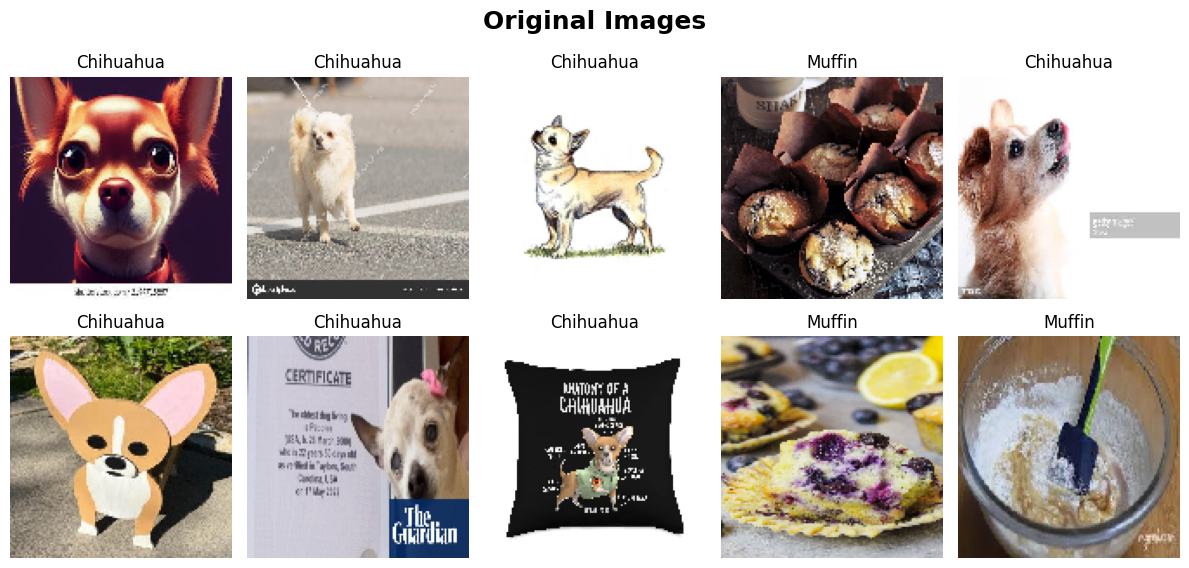

In [30]:
# Plot original images
# Randomly select 10 indices
num_samples = 10
total_images = len(original_images)
random_indices = np.random.choice(total_images, num_samples, replace=False)

# Select the images and labels at these random indices
random_images = original_images[random_indices]
random_labels = original_labels[random_indices]

# Plot the randomly selected images
plot_images(random_images, random_labels, "Original Images")

In [31]:
# Data augmentation using ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Generate augmented images
augmented_images_generator = datagen.flow_from_directory(train_data_path,
                                                         target_size=(128, 128),
                                                         batch_size=4733,
                                                         shuffle=True)

test_images_generator = test_datagen.flow_from_directory(test_data_path,
                                                        target_size=(128, 128),
                                                        batch_size=1184,
                                                        shuffle=False)

augmented_images, augmented_labels = next(augmented_images_generator)
test_images, test_labels = next(test_images_generator)

print("Shape of augmented images array:", augmented_images.shape)
print("Shape of test images array:", test_images.shape)

Found 4733 images belonging to 2 classes.
Found 1184 images belonging to 2 classes.
Shape of augmented images array: (4733, 128, 128, 3)
Shape of test images array: (1184, 128, 128, 3)


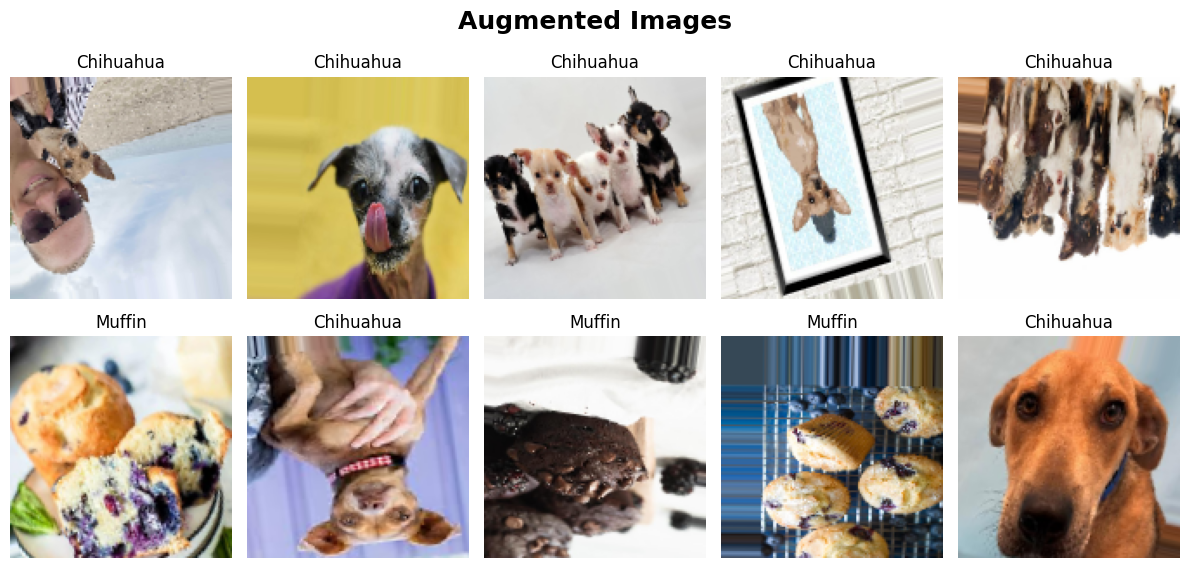

In [32]:
# Plot augmented images
# Choosing 10 images with the same random indeces selected before for preview
random_augmented_images = augmented_images[random_indices]
random_augmented_labels = augmented_labels[random_indices]
plot_images_from_flow(random_augmented_images, random_augmented_labels, "Augmented Images")

In [33]:
def plot_history(history):
    # Access training history
    training_loss = history.history['loss']
    training_accuracy = history.history['accuracy']
    validation_loss = history.history['val_loss']
    validation_accuracy = history.history['val_accuracy']

    # Plot training and validation loss
    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plot training and validation accuracy
    plt.plot(training_accuracy, label='Training Accuracy')
    plt.plot(validation_accuracy, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

In [34]:
# Determine the total number of augmented samples
total_samples = augmented_images.shape[0]

In [35]:
# Define the validation split ratio
validation_split = 0.2

# Calculate the number of samples for validation
num_validation_samples = int(total_samples * validation_split)

In [36]:
# Split the augmented data into training and validation sets
X_train = augmented_images[:-num_validation_samples]
y_train = augmented_labels[:-num_validation_samples]
X_val = augmented_images[-num_validation_samples:]
y_val = augmented_labels[-num_validation_samples:]

In [37]:
# Ensure consistency in data shapes
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)

Shape of X_train: (3787, 128, 128, 3)
Shape of y_train: (3787, 2)
Shape of X_val: (946, 128, 128, 3)
Shape of y_val: (946, 2)


In [95]:
print("Shape of test_images:", test_images.shape)
print("Shape of test_labels:", test_labels.shape)

Shape of test_images: (1184, 128, 128, 3)
Shape of test_labels: (1184, 2)


In [38]:
# Convert one-hot encoded labels to binary labels
y_train_binary = np.argmax(y_train, axis=1)
y_val_binary = np.argmax(y_val, axis=1)

# Ensure consistency in data shapes
print("Shape of y_train_binary:", y_train_binary.shape)
print("Shape of y_val_binary:", y_val_binary.shape)

Shape of y_train_binary: (3787,)
Shape of y_val_binary: (946,)


In [96]:
test_labels_binary = np.argmax(test_labels, axis=1)
print("Shape of test_labels_binary:", test_labels_binary.shape)

Shape of test_labels_binary: (1184,)


In [39]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

In [40]:
# Define ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [41]:
def create_history(model, number_of_epochs, batch_size, with_callback):
    if with_callback == True:
        history = model.fit(
        X_train,
        y_train_binary,
        epochs=number_of_epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val_binary),
        verbose=1,
        callbacks=[early_stopping, model_checkpoint]
        )
        return history
    else:
        history = model.fit(
            X_train,
            y_train_binary,
            epochs=number_of_epochs,
            batch_size=batch_size,
            validation_data=(X_val, y_val_binary),
            verbose=1,
        )
        return history

In [42]:
def print_model_results_table(model):
    results_training = model.evaluate(X_train, y_train_binary, verbose=0)
    results_validation = model.evaluate(X_val, y_val_binary, verbose=0)

    # Unpack the results
    train_loss, train_accuracy, train_precision, train_recall = results_training
    validation_loss, validation_accuracy, validation_precision, validation_recall = results_validation

    # Print the results
    results_dict = {
        'Metric': ['Loss', 'Accuracy', 'Precision', 'Recall'],
        'Training': [train_loss, train_accuracy, train_precision, train_recall],
        'Validation': [validation_loss, validation_accuracy, validation_precision, validation_recall]
    }

    results_df = pd.DataFrame(results_dict)
    table = tabulate(results_df, headers='keys', tablefmt='fancy_grid', stralign='center', numalign='center')

    # Print the formatted table
    print(table)

# Inital Model Development and tuning

In [43]:
model0 = Sequential([
    Input(shape=(128, 128, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model0.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'precision', 'recall'])
model0.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 127008)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    16,257,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,258,177 (62.02 MB)

 Trainable params: 16,258,177 (62.02 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
history0 = create_history(model0, 10, 32, False)

Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 46s 375ms/step - accuracy: 0.6043 - loss: 2.3481 - precision: 0.5731 - recall: 0.5614 - val_accuracy: 0.7442 - val_loss: 0.5116 - val_precision: 0.8529 - val_recall: 0.5346
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 44s 372ms/step - accuracy: 0.8154 - loss: 0.4371 - precision: 0.8103 - recall: 0.7810 - val_accuracy: 0.8076 - val_loss: 0.4557 - val_precision: 0.7930 - val_recall: 0.7857
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9010 - loss: 0.2669 - precision: 0.8980 - recall: 0.8895 - val_accuracy: 0.7674 - val_loss: 0.5057 - val_precision: 0.8768 - val_recall: 0.5737
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 82s 372ms/step - accuracy: 0.9409 - loss: 0.1753 - precision: 0.9493 - recall: 0.9215 - val_accuracy: 0.8087 - val_loss: 0.5050 - val_precision: 0.7843 - val_recall: 0.8041
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 82s 370ms/step - accuracy: 0.9800 - loss: 0.0912 - precision: 0.9833 - recall: 0.9739 - val_accuracy: 0.8097

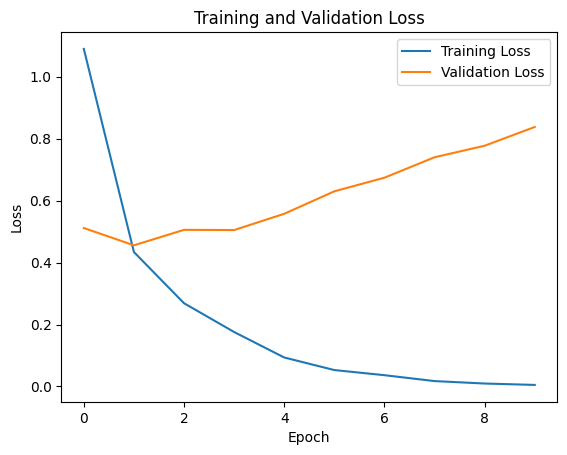

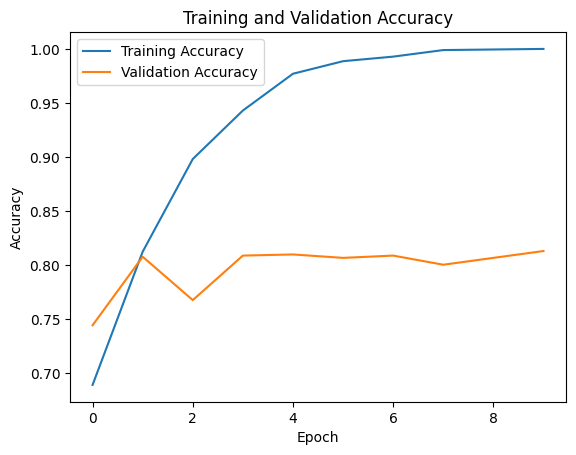

╒════╤═══════════╤════════════╤══════════════╕
│    │  Metric   │  Training  │  Validation  │
╞════╪═══════════╪════════════╪══════════════╡
│ 0  │   Loss    │ 0.00304223 │   0.837817   │
├────┼───────────┼────────────┼──────────────┤
│ 1  │ Accuracy  │     1      │   0.812896   │
├────┼───────────┼────────────┼──────────────┤
│ 2  │ Precision │     1      │   0.783664   │
├────┼───────────┼────────────┼──────────────┤
│ 3  │  Recall   │     1      │   0.817972   │
╘════╧═══════════╧════════════╧══════════════╛


In [45]:
plot_history(history0)
print_model_results_table(model0)

In [46]:
model1 = Sequential([
    Input(shape=(128, 128, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'precision', 'recall'])
model1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    14,745,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,765,505 (56.33 MB)

 Trainable params: 14,765,505 (56.33 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
history1 = create_history(model1, 10, 32, False)

Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 68s 548ms/step - accuracy: 0.5580 - loss: 1.2471 - precision: 0.5408 - recall: 0.5983 - val_accuracy: 0.7706 - val_loss: 0.5083 - val_precision: 0.7416 - val_recall: 0.7673
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 83s 561ms/step - accuracy: 0.7757 - loss: 0.4966 - precision: 0.7544 - recall: 0.7683 - val_accuracy: 0.7992 - val_loss: 0.4332 - val_precision: 0.7392 - val_recall: 0.8687
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 82s 561ms/step - accuracy: 0.8247 - loss: 0.4226 - precision: 0.7993 - recall: 0.8311 - val_accuracy: 0.8288 - val_loss: 0.3988 - val_precision: 0.8269 - val_recall: 0.7926
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 82s 562ms/step - accuracy: 0.8372 - loss: 0.3692 - precision: 0.8165 - recall: 0.8276 - val_accuracy: 0.8330 - val_loss: 0.4290 - val_precision: 0.8108 - val_recall: 0.8295
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 82s 560ms/step - accuracy: 0.8915 - loss: 0.2914 - precision: 0.8714 - recall: 0.8972 - val_accuracy: 0.8129

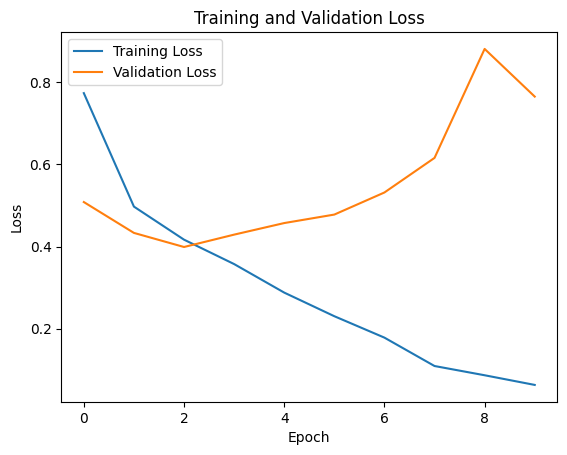

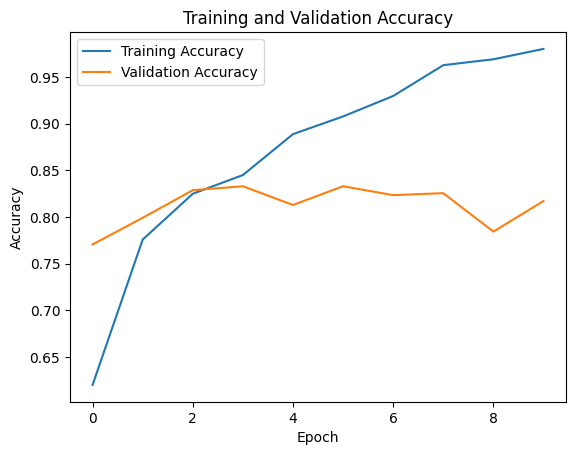

╒════╤═══════════╤════════════╤══════════════╕
│    │  Metric   │  Training  │  Validation  │
╞════╪═══════════╪════════════╪══════════════╡
│ 0  │   Loss    │  0.027009  │   0.76529    │
├────┼───────────┼────────────┼──────────────┤
│ 1  │ Accuracy  │  0.994191  │   0.817125   │
├────┼───────────┼────────────┼──────────────┤
│ 2  │ Precision │  0.997106  │   0.81295    │
├────┼───────────┼────────────┼──────────────┤
│ 3  │  Recall   │  0.99023   │   0.781106   │
╘════╧═══════════╧════════════╧══════════════╛


In [48]:
plot_history(history1)
print_model_results_table(model1)

<!-- From the training results you provided, it seems like the model is indeed learning, as indicated by the increasing accuracy with each epoch. However, there are some indications of overfitting, which we can see from the fluctuating validation accuracy and loss.

Here's a breakdown of the key observations and potential adjustments:

Training Accuracy: The training accuracy increases steadily with each epoch, indicating that the model is fitting the training data well.

Validation Accuracy: The validation accuracy fluctuates, reaching a peak at certain epochs but not consistently improving. This suggests that the model's performance on unseen data is inconsistent and might be overfitting.

Training Loss: The training loss consistently decreases with each epoch, which is expected as the model learns to minimize its error on the training data.

Validation Loss: The validation loss fluctuates, showing peaks and valleys throughout training. This is a sign of overfitting, where the model is learning to fit noise in the training data rather than capturing general patterns.

To address these issues, here are some potential adjustments:

Regularization: Introduce techniques like dropout or L2 regularization to prevent overfitting. Dropout randomly sets a fraction of input units to zero during training, which helps prevent overfitting by forcing the model to learn more robust features. L2 regularization adds a penalty term to the loss function, discouraging large weights in the network.

Early Stopping: Use early stopping to halt training when the validation loss stops improving, thus preventing overfitting. This technique saves the model at the point where it performs best on the validation set.

Data Augmentation: If applicable, increase the diversity of the training data by applying transformations like rotation, scaling, or flipping to the images. This can help the model generalize better to unseen data.

Model Complexity: Consider reducing the model's capacity by decreasing the number of parameters or layers if overfitting persists. Sometimes, simpler models generalize better, especially with limited training data.

Implementing these adjustments and monitoring the training process should help improve the model's performance and reduce overfitting.
 -->

In [49]:
model2 = Sequential([
    Input(shape=(128, 128, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'precision', 'recall'])
model2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,516,289 (24.86 MB)

 Trainable params: 6,516,289 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
history2 = create_history(model2, 10, 32, False)

Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 68s 555ms/step - accuracy: 0.6507 - loss: 0.6253 - precision: 0.6213 - recall: 0.6573 - val_accuracy: 0.7685 - val_loss: 0.4969 - val_precision: 0.8152 - val_recall: 0.6406
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 80s 539ms/step - accuracy: 0.7764 - loss: 0.4852 - precision: 0.7625 - recall: 0.7564 - val_accuracy: 0.8288 - val_loss: 0.4173 - val_precision: 0.7845 - val_recall: 0.8641
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 81s 535ms/step - accuracy: 0.8324 - loss: 0.4001 - precision: 0.8237 - recall: 0.8118 - val_accuracy: 0.8393 - val_loss: 0.3716 - val_precision: 0.7854 - val_recall: 0.8940
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 64s 540ms/step - accuracy: 0.8382 - loss: 0.3738 - precision: 0.8255 - recall: 0.8316 - val_accuracy: 0.8298 - val_loss: 0.3756 - val_precision: 0.7814 - val_recall: 0.8733
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 81s 534ms/step - accuracy: 0.8453 - loss: 0.3432 - precision: 0.8344 - recall: 0.8379 - val_accuracy: 0.8573

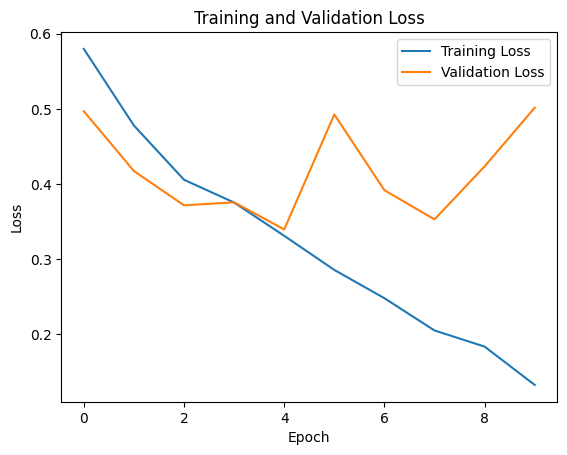

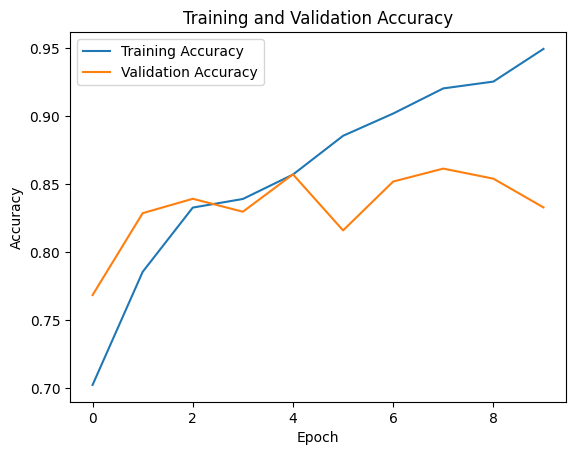

╒════╤═══════════╤════════════╤══════════════╕
│    │  Metric   │  Training  │  Validation  │
╞════╪═══════════╪════════════╪══════════════╡
│ 0  │   Loss    │  0.114015  │   0.501638   │
├────┼───────────┼────────────┼──────────────┤
│ 1  │ Accuracy  │  0.954317  │   0.832981   │
├────┼───────────┼────────────┼──────────────┤
│ 2  │ Precision │  0.996829  │   0.896552   │
├────┼───────────┼────────────┼──────────────┤
│ 3  │  Recall   │  0.903448  │   0.718894   │
╘════╧═══════════╧════════════╧══════════════╛


In [51]:
plot_history(history2)
print_model_results_table(model2)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,516,289 (24.86 MB)

 Trainable params: 6,516,289 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.5823 - loss: 0.6607 - precision: 0.5625 - recall: 0.5533
Epoch 1: val_accuracy improved from -inf to 0.76004, saving model to best_model.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 68s 552ms/step - accuracy: 0.5829 - loss: 0.6602 - precision: 0.5631 - recall: 0.5538 - val_accuracy: 0.7600 - val_loss: 0.5139 - val_precision: 0.7358 - val_recall: 0.7442
Epoch 2/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.7691 - loss: 0.5033 - precision: 0.7416 - recall: 0.7624
Epoch 2: val_accuracy improved from 0.76004 to 0.81501, saving model to best_model.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 66s 551ms/step - accuracy: 0.7691 - loss: 0.5033 - precision: 0.7416 - recall: 0.7624 - val_accuracy: 0.8150 - val_loss: 0.4393 - val_precision: 0.7738 - val_recall: 0.8433
Epoch 3/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.7968 - loss: 0.4632 - precision: 0.7730 - recall: 0.7973
Epoch 3: val_accuracy improved from 0.81501 to

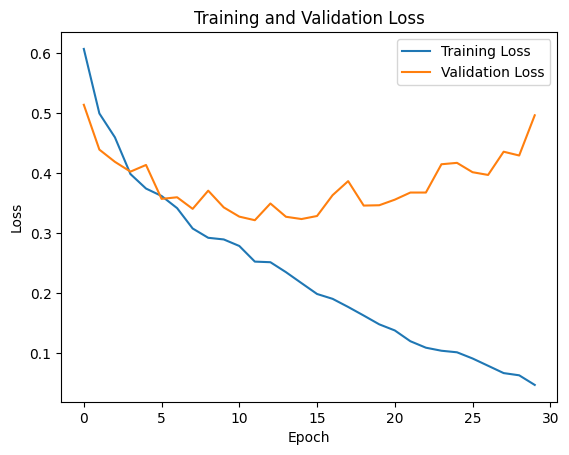

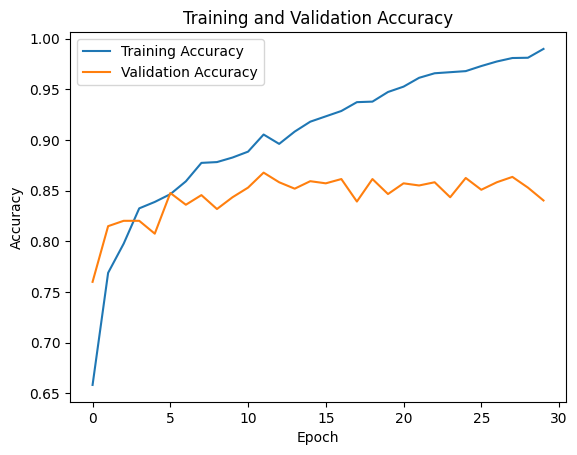

╒════╤═══════════╤════════════╤══════════════╕
│    │  Metric   │  Training  │  Validation  │
╞════╪═══════════╪════════════╪══════════════╡
│ 0  │   Loss    │ 0.0442369  │   0.496418   │
├────┼───────────┼────────────┼──────────────┤
│ 1  │ Accuracy  │  0.991814  │   0.840381   │
├────┼───────────┼────────────┼──────────────┤
│ 2  │ Precision │  0.984685  │   0.785859   │
├────┼───────────┼────────────┼──────────────┤
│ 3  │  Recall   │  0.997701  │   0.896313   │
╘════╧═══════════╧════════════╧══════════════╛


In [52]:
model3 = Sequential([
    Input(shape=(128, 128, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy', 'precision', 'recall'])
model3.summary()
history3 = create_history(model3, 30, 32, True)
plot_history(history3)
print_model_results_table(model3)

# 5-Fold Cross Validation

In [68]:
from sklearn.model_selection import StratifiedKFold

In [69]:
def zero_one_loss(y_true, y_pred):
    y_pred_rounded = np.round(y_pred)
    return np.mean(np.abs(y_true - y_pred_rounded))

In [72]:
# Define the cross-validation function
def cross_validate_model(model, X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_results = {'val_loss': [], 'val_accuracy': [], 'val_precision': [], 'val_recall': [], 'val_zero_one_loss': []}

    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]

        # Initialize a new model for each fold
        model_cv = tf.keras.models.clone_model(model)
        model_cv.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                         loss='binary_crossentropy',
                         metrics=['accuracy', 'precision', 'recall'])

        print(f"Training fold {fold}/{n_splits}...")
        history = model_cv.fit(X_train_fold, y_train_fold, epochs=15, batch_size=32, verbose=1,
                               validation_data=(X_val_fold, y_val_fold))

        # Evaluate on validation fold
        val_loss, val_accuracy, val_precision, val_recall = model_cv.evaluate(X_val_fold, y_val_fold, verbose=1)
        
        # Predict on validation fold and calculate zero-one loss
        y_val_pred = model_cv.predict(X_val_fold)
        val_zero_one_loss = zero_one_loss(y_val_fold, y_val_pred)
        
        # Store results
        cv_results['val_loss'].append(val_loss)
        cv_results['val_accuracy'].append(val_accuracy)
        cv_results['val_precision'].append(val_precision)
        cv_results['val_recall'].append(val_recall)
        cv_results['val_zero_one_loss'].append(val_zero_one_loss)

    # Average results across folds
    avg_results = {metric: np.mean(values) for metric, values in cv_results.items()}
    return avg_results

In [73]:
cv_results_model2 = cross_validate_model(model2, X_train, y_train_binary)

Training fold 1/5...
Epoch 1/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 57s 571ms/step - accuracy: 0.5846 - loss: 0.6576 - precision: 0.5598 - recall: 0.5582 - val_accuracy: 0.7243 - val_loss: 0.5623 - val_precision: 0.7439 - val_recall: 0.6092
Epoch 2/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 81s 558ms/step - accuracy: 0.7330 - loss: 0.5378 - precision: 0.7135 - recall: 0.7047 - val_accuracy: 0.7836 - val_loss: 0.4728 - val_precision: 0.8262 - val_recall: 0.6695
Epoch 3/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 82s 562ms/step - accuracy: 0.7910 - loss: 0.4569 - precision: 0.7686 - recall: 0.7634 - val_accuracy: 0.8127 - val_loss: 0.4259 - val_precision: 0.8065 - val_recall: 0.7787
Epoch 4/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 54s 566ms/step - accuracy: 0.8209 - loss: 0.4211 - precision: 0.8096 - recall: 0.8071 - val_accuracy: 0.8140 - val_loss: 0.4207 - val_precision: 0.8581 - val_recall: 0.7126
Epoch 5/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 574ms/step - accuracy: 0.8328 - loss: 0.3878 - precision: 0.8278 - recall: 0.8136 - val_accur

NameError: name 'cv_results_model3' is not defined

In [74]:
print("Cross-Validation Results for Model 2:", cv_results_model2)

Cross-Validation Results for Model 2: {'val_loss': 0.38195650577545165, 'val_accuracy': 0.8418259859085083, 'val_precision': 0.825643253326416, 'val_recall': 0.8431034564971924, 'val_zero_one_loss': 0.4978195188430877}


In [75]:
cv_results_model3 = cross_validate_model(model3, X_train, y_train_binary)

Training fold 1/5...
Epoch 1/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 58s 580ms/step - accuracy: 0.5935 - loss: 0.6600 - precision: 0.5714 - recall: 0.5697 - val_accuracy: 0.6966 - val_loss: 0.5884 - val_precision: 0.7588 - val_recall: 0.4971
Epoch 2/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 55s 577ms/step - accuracy: 0.7195 - loss: 0.5473 - precision: 0.6906 - recall: 0.7139 - val_accuracy: 0.7718 - val_loss: 0.5070 - val_precision: 0.7814 - val_recall: 0.6983
Epoch 3/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 82s 574ms/step - accuracy: 0.7760 - loss: 0.4877 - precision: 0.7517 - recall: 0.7523 - val_accuracy: 0.8127 - val_loss: 0.4589 - val_precision: 0.8102 - val_recall: 0.7730
Epoch 4/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 82s 572ms/step - accuracy: 0.7924 - loss: 0.4578 - precision: 0.7759 - recall: 0.7684 - val_accuracy: 0.7850 - val_loss: 0.4637 - val_precision: 0.8439 - val_recall: 0.6523
Epoch 5/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 589ms/step - accuracy: 0.8065 - loss: 0.4230 - precision: 0.7788 - recall: 0.8105 - val_accur

In [76]:
print("Cross-Validation Results for Model 3:", cv_results_model3)

Cross-Validation Results for Model 3: {'val_loss': 0.3663232386112213, 'val_accuracy': 0.8423561334609986, 'val_precision': 0.8611047387123107, 'val_recall': 0.788505756855011, 'val_zero_one_loss': 0.4937409608506786}


# Tuning

In [77]:
import keras_tuner as kt

In [ ]:
def build_model(hp):
    model = Sequential([
        Input(shape=(128, 128, 3)),
        Conv2D(hp.Int('conv_1_filters', min_value=32, max_value=128, step=32), (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(hp.Int('conv_2_filters', min_value=64, max_value=256, step=64), (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(hp.Int('conv_3_filters', min_value=128, max_value=256, step=128), (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(hp.Int('dense_units', min_value=128, max_value=512, step=128), activation='relu'),
        Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG', default=1e-3)),
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'precision', 'recall'])
    
    return model

In [82]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='hyperband_dir',
    project_name='model3_tuning'
)

In [ ]:
tuner.search(X_train, y_train_binary, epochs=15, validation_split=0.2)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.9903 - loss: 0.0491 - precision: 0.9880 - recall: 0.9909
Epoch 1: val_accuracy did not improve from 0.86786
119/119 ━━━━━━━━━━━━━━━━━━━━ 68s 562ms/step - accuracy: 0.9903 - loss: 0.0491 - precision: 0.9880 - recall: 0.9908 - val_accuracy: 0.8541 - val_loss: 0.4668 - val_precision: 0.8217 - val_recall: 0.8710
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 0.9876 - loss: 0.0427 - precision: 0.9872 - recall: 0.9860
Epoch 2: val_accuracy did not improve from 0.86786
119/119 ━━━━━━━━━━━━━━━━━━━━ 85s 581ms/step - accuracy: 0.9876 - loss: 0.0428 - precision: 0.9872 - recall: 0.9860 - val_accuracy: 0.8457 - val_loss: 0.5069 - val_precision: 0.8750 - val_recall: 0.7742
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.9899 - loss: 0.0373 - precision: 0.9925 - recall: 0.9851
Epoch 3: val_accuracy did not improve from 0.86786
119/119 ━━━━━━━━━━━━━━━━━━━━ 79s 559ms/step - accuracy: 0.9899 - los

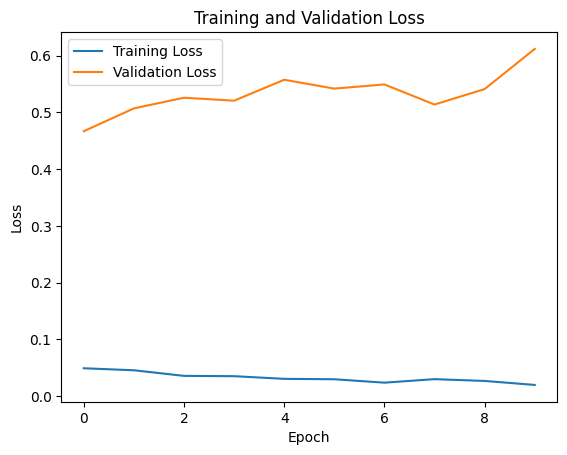

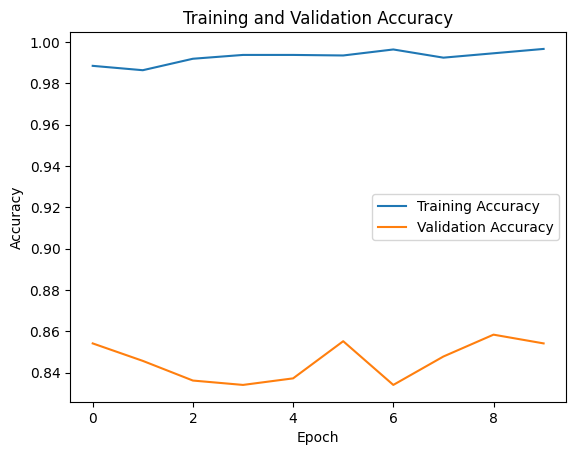

NotImplementedError: Cannot convert a symbolic tf.Tensor (sequential_1_1/dense_3_1/Sigmoid:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported.

In [86]:
tuned_model = Sequential([
    Input(shape=(128, 128, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])
tuned_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00015174),
              loss='binary_crossentropy',
              metrics=['accuracy', 'precision', 'recall', zero_one_loss])
tuned_history = create_history(model3, 10, 32, True)
plot_history(tuned_history)